In [138]:
import os 
import nibabel as nib
import numpy as np
import pandas as pd

In [3]:
import os, sys, importlib
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)

c:\Users\Admin\Documents\msc_project\Image-processing-strategies


In [88]:
import monkey_tools.extract_metric
importlib.reload(monkey_tools.extract_metric)

from monkey_tools.extract_metric import multi_algo_comp_wm_gm_custom, single_algo_comp # re-import updated function

In [262]:
bgfr_comp_vector = ['def_pdf', 'opt_pdf','def_lbv', 'opt_lbv', 'opt_sharp', 'opt_resharp']
di_comp_vector = ["def_tkd", "opt_tkd", "def_iLSQR",  "opt_iLSQR", "auto_iLSQR", 
                    "def_closedForm",  "opt_closedForm", "auto_closedForm", "def_fansi", "opt_fansi"]

# <span style="color:#FFCC80">In vivo Swiss mk.2 data processing </span> </br>
Compare and analyze if using optimized parameters improves or deteriorates the final local fields </br>

Keywords: </br>
* sw = slicewise
* pp = pipeline

In [ ]:
# We have 4 subjects inside
subjects = ['hc1', 'hc2', 'sci1', 'sci2']
measurements = ['m1', 'm2', 'm3', 'm4']
# Now, from the root folder, select all the algorithms you want to compare
# They will be checked for all the subjects and all the measurements, if they don't exist they are skipped
# Therefore try to have the same folder names for any tests you want to compare
algo_comparing = []
rows = []


In [2]:
root_dir = r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing"

In [3]:
# Lets create a "edge mask" of the spinal cord for hc2m1 for image showing in abstract and paper
sc_mask_hc2m1_img = nib.load(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\custom1_sc_msk.nii.gz")
sc_mask_hc2m1_data = sc_mask_hc2m1_img.get_fdata()

In [ ]:
from scipy.ndimage import binary_erosion, binary_dilation
edges_hc2m1 = binary_dilation(sc_mask_hc2m1_data)  & ~binary_erosion(sc_mask_hc2m1_data)
edges_sc_msk_hc2m1_img = nib.Nifti1Image(edges_hc2m1.astype(np.uint8) , affine=sc_mask_hc2m1_img.affine)

In [ ]:
nib.save(edges_sc_msk_hc2m1_img,r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\hc2_m1_custiom_sc_edges_msk.nii.gz" )

# <span style="color:#ff007f">Translation of in-sillico results to in-vivo </span> </br>

## <span style="color:#ffaa00">FANSI in-vivo checks</span> </br>
We wil use subject hc2 measurement 1 because it had the best perforiming local field - with optimized pdf


In [ ]:
# # We have 4 subjects inside
subjects = ['hc2']
measurements = ['m1']
sanitity_check_dir =  r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\chi_map\fansi\all_bgfr_to_custom_fansi"

# Put opt_pdf_test_tolerance after tansi and then lambda test folder names:
#'opt_pdf_test_tolerance/def_tol', 'opt_pdf_test_tolerance/higher_tol', 'opt_pdf_test_tolerance/lower_tol', from the tolerance tests, all the other parameters are default
# the best was the one with lower tolerance at 0.761 but default got 0.760 so neglibible difference
# Now testing the lambda, fixing tolerance to the default, fixing mu2 to 0.5 and gradient consistency to 0.1
#-#
# II. Lambda tests, put this after fansi: opt_pdf_to_opt_fansi/I_lambda_tests
# Folder names: "test1_lambda_0_00033", "test2_lambda_def", "test3_lambda_0_001"
#-#
# III mu1 tests, put opt_pdf_to_opt_fansi\II_mu1_tests after fansi
# Foldernames: ['test1_lower_mu1', 'test2_higher_mu1']
#-#
# IV mu2 put opt_pdf_to_opt_fansi\III_mu2_tests after fansi
# Foldernames: ['test1_0_3', 'test2_0_7', 'test3_0_1']
#-#
# V Extra tests, put opt_pdf_to_opt_fansi\extra_tests after fansi
# Foldernames: ['test1', 'test2', 'test3', 'test4', 'test5']
#-#
# Lastly to compare with LBV, default BGFR algos and more
# Put all_bgfr_to_custom1_fansi after fansi, this "custom1" fansi uses lambda = 0.001 , mu2 = 1 and mu1 = 1
# Custom 1: Using opt pdf into custom 1 fansi 
# Custom 2: default lbv into fansi with default params
# Custom 3: using default pdf into fansi with default params
# Custom 4: opt lbv into custom 1 fansi
# Custom 5: opt resharp into custom 1 fansi
# Results where: 
# Sorting by final metric: 4 > 5 > 1 > 3 > 2
# Sorting by delta_chi wm-gm: 4 > 3 > 5 > 1 > 2

test_folders = ['custom1', 'custom2', 'custom3', 'custom4', 'custom5']
fansi_testing_chi_map_rows = []

In [126]:
# Now lets collect rows for the testin folders
fansi_testing_chi_map_rows = []
for algo in test_folders:
            
            # Firsst, define the path pointers
            
            chi_map_path = os.path.join(sanitity_check_dir, algo,'Sepia_Chimap.nii.gz')
            if chi_map_path is None or not os.path.exists(chi_map_path):
                print(f"Skipping {chi_map_path} as it does not exist.")
                continue

            gm_msk_path = r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\custom_hc2_m1_gm_msk.nii.gz"
            wm_msk_path = r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\custom_hc2_m1_wm_msk.nii.gz"

            # Load data
            chi_map_img = nib.load(chi_map_path)
            chi_map_data = chi_map_img.get_fdata()

            gm_vals = chi_map_data[(gm_mask == 1) & (chi_map_data != 0)].ravel()
            wm_vals = chi_map_data[(wm_mask == 1) & (chi_map_data != 0)].ravel()

            gm_mask = nib.load(gm_msk_path).get_fdata()
            total_vox_gm = np.sum(gm_mask==1) 
            wm_mask = nib.load(wm_msk_path).get_fdata()
            total_vox_wm = np.sum(wm_mask==1)

            # Compute metrics for GM and WM
            gm_mean = np.mean(chi_map_data[gm_mask==1])
            gm_std = np.std(chi_map_data[gm_mask==1])
            n_gm = gm_mean.size
            wm_mean = np.mean(chi_map_data[wm_mask==1])
            wm_std = np.std(chi_map_data[wm_mask==1])
            n_wm = wm_mean.size

            # Compute how many voxels are in the mask
            gm_nonzero_vox = np.sum(chi_map_data[gm_mask==1] != 0)
            wm_nonzero_vox = np.sum(chi_map_data[wm_mask==1] != 0)

            # Compute the contrast metric
            # We want to maximize the contrast between GM and WM
            # WM mean should be negative, if it is positive the contrast will be lower this way
            contrast = np.abs(gm_mean - wm_mean)

            normalizer_denominator_2 = np.sqrt(gm_std**2 + wm_std**2) 
           
            raw_metric = contrast / normalizer_denominator_2 if normalizer_denominator_2 != 0 else 0 # Just in case that the std is 0 - to avoid division by zero

            # Now we penalize if the algo eroded the mask
            gm_penality = gm_nonzero_vox / total_vox_gm 
            wm_penality = wm_nonzero_vox / total_vox_wm

            # Final metric:
            final_metric = raw_metric * gm_penality * wm_penality

            # Now collect row and add to data frame
            fansi_testing_chi_map_rows.append({
                    
                'subject': 'hc2',
                'measurement': 'm1',
                'test_folder': algo,

                'mean_gm': gm_mean,
                'std_gm': gm_std,
                'total_vox_gm': total_vox_gm,
                'nonzero_vox_gm': gm_nonzero_vox,
                'gm_penality': gm_penality,

                'mean_wm': wm_mean,
                'std_wm': wm_std,
                'total_vox_wm': total_vox_wm,
                'nonzero_vox_wm': wm_nonzero_vox,
                'wm_penality': wm_penality,
    
                'contrast_factor': contrast,
                'pooled_std_denominator': normalizer_denominator_2,
                #'raw_metric': raw_metric,
                
                'final_metric': final_metric
            })


# Create the data frame
sanity_check_df = pd.DataFrame(fansi_testing_chi_map_rows)
# No need to save because this is just a sanity check

In [128]:
sorted_sanity_check_df = sanity_check_df.sort_values(by='contrast_factor', ascending=False)
sorted_sanity_check_df

,subject,measurement,test_folder,mean_gm,std_gm,total_vox_gm,nonzero_vox_gm,gm_penality,mean_wm,std_wm,total_vox_wm,nonzero_vox_wm,wm_penality,contrast_factor,pooled_std_denominator,final_metric
3,hc2,m1,custom4,0.011256,0.011829,477,476,0.997904,-0.002384,0.007704,2252,2252,1.0,0.013641,0.014116,0.964301
2,hc2,m1,custom3,0.009873,0.011427,477,476,0.997904,-0.002091,0.011254,2252,2252,1.0,0.011965,0.016038,0.744444
4,hc2,m1,custom5,0.008833,0.010036,477,476,0.997904,-0.001871,0.006516,2252,2252,1.0,0.010704,0.011966,0.892686
0,hc2,m1,custom1,0.008399,0.010199,477,476,0.997904,-0.001779,0.007020,2252,2252,1.0,0.010178,0.012381,0.820346
1,hc2,m1,custom2,0.004101,0.008378,477,476,0.997904,-0.000869,0.003675,2252,2252,1.0,0.004970,0.009149,0.542086


# <span style="color:#6aff0e">All dub BGFR and DI in-vivo analysis </span> </br>
We compare the results of before vs after DI algo optimization. </br>
For DI we use the best performing algorithm: Optimized PDF  

## hc1 m2

### <span style="color:#3FC2E0"> DI </span> </br>

In [ ]:
hc1_m2_test_folders = ['opt_TKD', 'def_TKD', 'opt_iLSQR', 'def_iLSQR', 'opt_fansi', 'def_fansi', 'def_closedForm', 'opt_closedForm'] 

# After some testing, remove MEDI due to wrong mean calculation, something wrong with lambda 'def_MEDI', 'opt_MEDI'
hc1_m2_root_dir =  r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc1\m2\chi_map\opt_pdf_to_all_DI"
hc1_m2_gm_msk_path = r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc1\m2\custom_hc1_m2_gm_msk.nii.gz"
hc1_m2_wm_msk_path = r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc1\m2\custom_hc1_m2_wm_msk.nii.gz"
hc1_m2_sc_msk_path = r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc1\m2\custom_hc1_m2_sc_msk.nii.gz"
hc1_m2_opt_pdf_to_all_DI_df = multi_algo_comp_wm_gm_custom('hc1', 'm2', hc1_m2_root_dir, hc1_m2_test_folders, hc1_m2_gm_msk_path, hc1_m2_wm_msk_path)


In [78]:
contrast_sorted_hc1_m2 = hc1_m2_opt_pdf_to_all_DI_df.sort_values(by='contrast_factor', ascending=False)
noise_sorted_hc1_m2 = hc1_m2_opt_pdf_to_all_DI_df.sort_values(by='std_denominator', ascending=True)
final_metric_sorted_hc1_m2 = hc1_m2_opt_pdf_to_all_DI_df.sort_values(by='final_metric', ascending=False)

In [80]:
contrast_sorted_hc1_m2[['subject', 'measurement', 'test_folder', 'contrast_factor']]

,subject,measurement,test_folder,contrast_factor
0,hc1,m2,opt_TKD,0.011174
7,hc1,m2,opt_closedForm,0.011151
2,hc1,m2,opt_iLSQR,0.011096
1,hc1,m2,def_TKD,0.011037
5,hc1,m2,def_fansi,0.010919
6,hc1,m2,def_closedForm,0.008853
3,hc1,m2,def_iLSQR,0.008813
4,hc1,m2,opt_fansi,0.003172


In [81]:
noise_sorted_hc1_m2[['subject', 'measurement', 'test_folder', 'std_denominator']]

,subject,measurement,test_folder,std_denominator
4,hc1,m2,opt_fansi,0.003533
6,hc1,m2,def_closedForm,0.010628
3,hc1,m2,def_iLSQR,0.010819
5,hc1,m2,def_fansi,0.016210
1,hc1,m2,def_TKD,0.016440
2,hc1,m2,opt_iLSQR,0.016809
7,hc1,m2,opt_closedForm,0.016899
0,hc1,m2,opt_TKD,0.016996


In [82]:
final_metric_sorted_hc1_m2[['subject', 'measurement', 'test_folder', 'final_metric']]

,subject,measurement,test_folder,final_metric
4,hc1,m2,opt_fansi,0.895803
6,hc1,m2,def_closedForm,0.831120
3,hc1,m2,def_iLSQR,0.812781
5,hc1,m2,def_fansi,0.672074
1,hc1,m2,def_TKD,0.669797
2,hc1,m2,opt_iLSQR,0.658606
7,hc1,m2,opt_closedForm,0.658362
0,hc1,m2,opt_TKD,0.655990


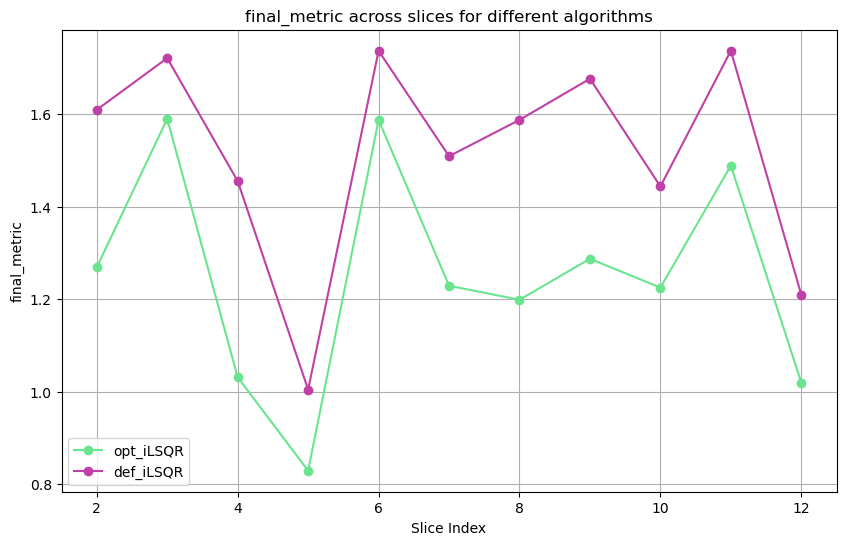

In [144]:
# Throughslice comparison for hc1 m2 opt pdf to all DI
# We can use the same masks, the only thing different is we want to compare algos individually

importlib.reload(monkey_tools.extract_metric)

from monkey_tools.extract_metric import single_algo_comp 


only_iLSQR = ['opt_iLSQR', 'def_iLSQR']
hc1_m2_iLSQR_throughslice_df = single_algo_comp('hc1', 'm2', hc1_m2_root_dir, only_iLSQR, hc1_m2_sc_msk_path, hc1_m2_gm_msk_path, hc1_m2_wm_msk_path, metric='final_metric')

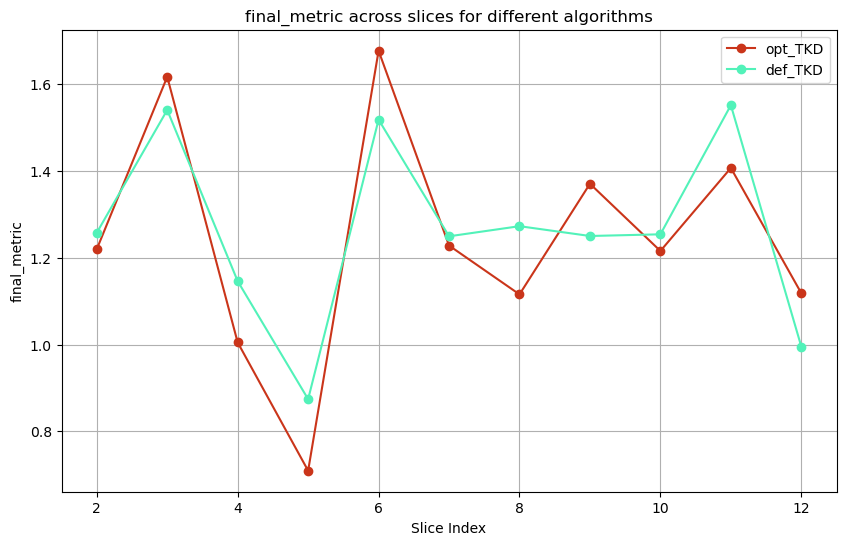

In [145]:
only_TKD = ['opt_TKD', 'def_TKD']
hc1_m2_TKD_throughslice_df = single_algo_comp('hc1', 'm2', hc1_m2_root_dir, only_TKD, hc1_m2_sc_msk_path, hc1_m2_gm_msk_path, hc1_m2_wm_msk_path, metric='final_metric')

## hc2 m1

### <span style="color:#3FC2E0"> DI </span> </br>

In [ ]:
hc2_m1_test_folders = ['opt_TKD', 'def_TKD', 'opt_iLSQR', 'def_iLSQR', 'opt_fansi', 'def_fansi', 'def_closedForm', 'opt_closedForm'] 
# After some testing, remove MEDI due to wrong mean calculation, something wrong with lambda 'def_MEDI', 'opt_MEDI'
hc2_m1_root_dir =  r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\chi_map\opt_pdf_to_all_DI"
hc2_m1_sc_msk_path = r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\hc2_m1_sc_msk.nii.gz"
hc2_m1_gm_msk_path = r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\custom_hc2_m1_gm_msk.nii.gz"
hc2_m1_wm_msk_path = r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\custom_hc2_m1_wm_msk.nii.gz"
hc2_m1_opt_pdf_to_all_DI_df = multi_algo_comp_wm_gm_custom('hc2', 'm1', hc2_m1_root_dir, hc2_m1_test_folders, hc2_m1_gm_msk_path, hc2_m1_wm_msk_path)

# Now for BGFR 
hc2_m1_bgfr_test_folders = []

In [109]:
contrast_sorted_hc2_m1 = hc2_m1_opt_pdf_to_all_DI_df.sort_values(by='contrast_factor', ascending=False)
noise_sorted_hc2_m1 = hc2_m1_opt_pdf_to_all_DI_df.sort_values(by='std_denominator', ascending=True)
final_metric_sorted_hc2_m1 = hc2_m1_opt_pdf_to_all_DI_df.sort_values(by='final_metric', ascending=False)

In [110]:
contrast_sorted_hc2_m1.head(10)
# Now just show subject, measurement and contrast factor columns
contrast_sorted_hc2_m1[['subject', 'measurement', 'test_folder', 'contrast_factor']]

,subject,measurement,test_folder,contrast_factor
1,hc2,m1,def_TKD,0.012882
2,hc2,m1,opt_iLSQR,0.012852
0,hc2,m1,opt_TKD,0.012829
7,hc2,m1,opt_closedForm,0.012729
5,hc2,m1,def_fansi,0.012673
3,hc2,m1,def_iLSQR,0.009860
6,hc2,m1,def_closedForm,0.009739
4,hc2,m1,opt_fansi,0.002587


In [111]:
noise_sorted_hc2_m1.head(10)
noise_sorted_hc2_m1[['subject', 'measurement', 'test_folder', 'std_denominator']]

,subject,measurement,test_folder,std_denominator
4,hc2,m1,opt_fansi,0.003360
6,hc2,m1,def_closedForm,0.009891
3,hc2,m1,def_iLSQR,0.010331
5,hc2,m1,def_fansi,0.015307
1,hc2,m1,def_TKD,0.015420
7,hc2,m1,opt_closedForm,0.015668
2,hc2,m1,opt_iLSQR,0.015863
0,hc2,m1,opt_TKD,0.016033


In [112]:
final_metric_sorted_hc2_m1.head(10)
final_metric_sorted_hc2_m1[['subject', 'measurement', 'test_folder', 'final_metric']]

,subject,measurement,test_folder,final_metric
6,hc2,m1,def_closedForm,0.982553
3,hc2,m1,def_iLSQR,0.952350
1,hc2,m1,def_TKD,0.833622
5,hc2,m1,def_fansi,0.826176
7,hc2,m1,opt_closedForm,0.810717
2,hc2,m1,opt_iLSQR,0.808528
0,hc2,m1,opt_TKD,0.798459
4,hc2,m1,opt_fansi,0.768361


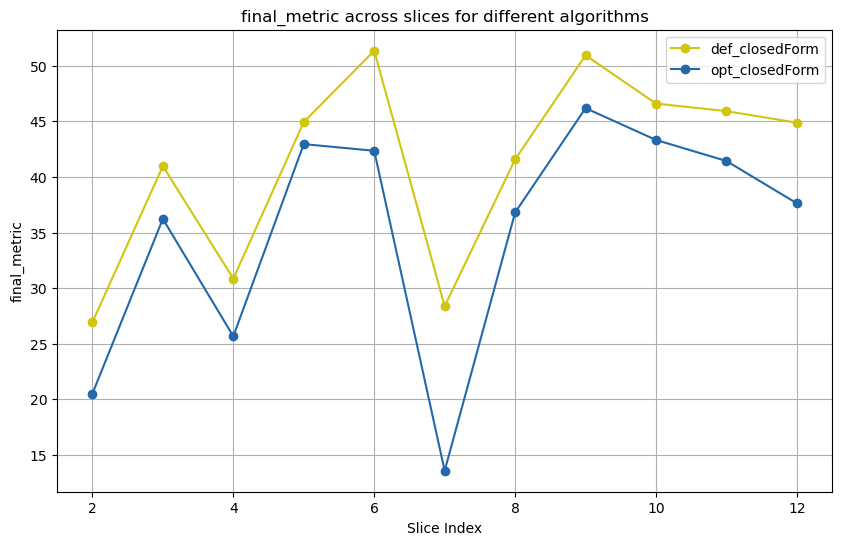

In [159]:
# Throughslice comparison for hc1 m2 opt pdf to all DI
# We can use the same masks, the only thing different is we want to compare algos individually

importlib.reload(monkey_tools.extract_metric)

from monkey_tools.extract_metric import single_algo_comp 

only_closedForm = ['def_closedForm', 'opt_closedForm']
only_iLSQR = ['opt_iLSQR', 'def_iLSQR']
hc2_m1_throughslice_df = single_algo_comp('hc2', 'm1', hc2_m1_root_dir, only_closedForm, hc2_m1_sc_msk_path, hc2_m1_gm_msk_path, hc2_m1_wm_msk_path, metric='final_metric')

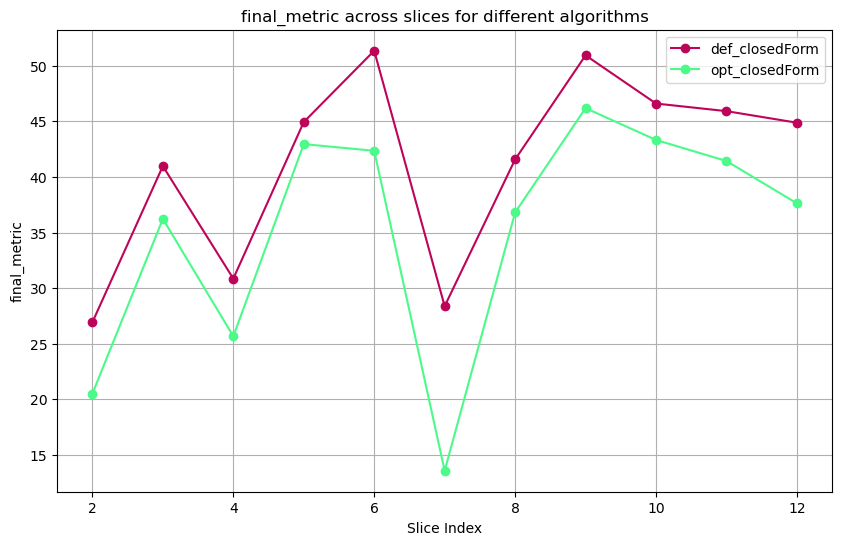

In [149]:
# Throughslice comparison for hc1 m2 opt pdf to all DI
# We can use the same masks, the only thing different is we want to compare algos individually

importlib.reload(monkey_tools.extract_metric)

from monkey_tools.extract_metric import single_algo_comp 

only_closedForm = ['def_closedForm', 'opt_closedForm']
only_iLSQR = ['opt_iLSQR', 'def_iLSQR']
hc2_m1_iLSQR_throughslice_df = single_algo_comp('hc2', 'm1', hc2_m1_root_dir, only_closedForm, hc2_m1_sc_msk_path, hc2_m1_gm_msk_path, hc2_m1_wm_msk_path, metric='final_metric')

## chi_003

### <span style="color:#3FC2E0"> DI </span> </br>

In [256]:
chi_003_m2_test_folders = ["def_tkd", "opt_tkd", "def_iLSQR",  "opt_iLSQR", "auto_iLSQR", 
                    "def_closedForm",  "opt_closedForm", "auto_closedForm", "def_fansi", "opt_fansi"]

chi_003_m2_root_dir =  r"E:\msc_data\sc_qsm\neuropoly_data\chi_003\qsm_processing\2nd_3D_meGRE\auto_di_comp\comp_di"
chi_003_sc_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_003\qsm_processing\2nd_3D_meGRE\chi_003_m2_sc_msk_T0000.nii.gz"
chi_003_m2_gm_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_003\qsm_processing\2nd_3D_meGRE\chi_003_m2_gm_msk.nii.gz"
chi_003_m2_wm_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_003\qsm_processing\2nd_3D_meGRE\chi_003_m2_wm_msk.nii.gz"
chi_003_m2_opt_pdf_to_all_DI_df = multi_algo_comp_wm_gm_custom('chi_003', 'm2', "chi_map", chi_003_m2_root_dir, chi_003_m2_test_folders, chi_003_m2_gm_msk_path, chi_003_m2_wm_msk_path)

In [257]:
# Checking for voxel count for discussion and interpretation of results
chi_003_m2_opt_pdf_to_all_DI_df[['subject', 'measurement', 'total_vox_gm','total_vox_wm']]


,subject,measurement,total_vox_gm,total_vox_wm
0,chi_003,m2,864,4319
1,chi_003,m2,864,4319
2,chi_003,m2,864,4319
3,chi_003,m2,864,4319
4,chi_003,m2,864,4319
5,chi_003,m2,864,4319
6,chi_003,m2,864,4319
7,chi_003,m2,864,4319
8,chi_003,m2,864,4319
9,chi_003,m2,864,4319


In [258]:
contrast_sorted_chi_003_m2 = chi_003_m2_opt_pdf_to_all_DI_df.sort_values(by='contrast_factor', ascending=False)
noise_sorted_chi_003_m2 = chi_003_m2_opt_pdf_to_all_DI_df.sort_values(by='std_denominator', ascending=True)
final_metric_sorted_chi_003_m2 = chi_003_m2_opt_pdf_to_all_DI_df.sort_values(by='final_metric', ascending=False)

In [272]:
final_metric_sorted_chi_003_m2[['subject', 'measurement', 'test_folder', 'mean_gm', "std_gm",'mean_wm',"std_wm", 'final_metric']]

,subject,measurement,test_folder,mean_gm,std_gm,mean_wm,std_wm,final_metric
4,chi_003,m2,auto_iLSQR,0.008311,0.007700,-0.001603,0.005718,1.409418
7,chi_003,m2,auto_closedForm,0.007992,0.007693,-0.001541,0.005128,1.405986
5,chi_003,m2,def_closedForm,0.009049,0.008834,-0.001745,0.005987,1.379098
2,chi_003,m2,def_iLSQR,0.009447,0.008887,-0.001822,0.006820,1.371567
0,chi_003,m2,def_tkd,0.011203,0.011741,-0.002161,0.008460,1.259101
3,chi_003,m2,opt_iLSQR,0.011235,0.011769,-0.002167,0.008521,1.257642
8,chi_003,m2,def_fansi,0.011018,0.011685,-0.002125,0.008252,1.252665
6,chi_003,m2,opt_closedForm,0.011201,0.011790,-0.002160,0.008515,1.252633
1,chi_003,m2,opt_tkd,0.011222,0.011829,-0.002164,0.008548,1.250690
9,chi_003,m2,opt_fansi,0.004894,0.006246,-0.000944,0.002860,1.158795


In [260]:
contrast_sorted_chi_003_m2[['subject', 'measurement', 'test_folder', 'contrast_factor']]

,subject,measurement,test_folder,contrast_factor
3,chi_003,m2,opt_iLSQR,0.013402
1,chi_003,m2,opt_tkd,0.013387
0,chi_003,m2,def_tkd,0.013364
6,chi_003,m2,opt_closedForm,0.013361
8,chi_003,m2,def_fansi,0.013143
2,chi_003,m2,def_iLSQR,0.011269
5,chi_003,m2,def_closedForm,0.010794
4,chi_003,m2,auto_iLSQR,0.009914
7,chi_003,m2,auto_closedForm,0.009533
9,chi_003,m2,opt_fansi,0.005838


In [271]:
noise_sorted_chi_003_m2[['subject', 'measurement', 'test_folder', 'std_gm', 'std_wm', 'std_denominator']]

,subject,measurement,test_folder,std_gm,std_wm,std_denominator
9,chi_003,m2,opt_fansi,0.006246,0.002860,0.004857
7,chi_003,m2,auto_closedForm,0.007693,0.005128,0.006537
4,chi_003,m2,auto_iLSQR,0.007700,0.005718,0.006782
5,chi_003,m2,def_closedForm,0.008834,0.005987,0.007546
2,chi_003,m2,def_iLSQR,0.008887,0.006820,0.007921
8,chi_003,m2,def_fansi,0.011685,0.008252,0.010115
0,chi_003,m2,def_tkd,0.011741,0.008460,0.010233
3,chi_003,m2,opt_iLSQR,0.011769,0.008521,0.010274
6,chi_003,m2,opt_closedForm,0.011790,0.008515,0.010284
1,chi_003,m2,opt_tkd,0.011829,0.008548,0.010319


In [261]:
final_metric_sorted_chi_003_m2[['subject', 'measurement', 'test_folder', 'final_metric']]

,subject,measurement,test_folder,final_metric
4,chi_003,m2,auto_iLSQR,1.409418
7,chi_003,m2,auto_closedForm,1.405986
5,chi_003,m2,def_closedForm,1.379098
2,chi_003,m2,def_iLSQR,1.371567
0,chi_003,m2,def_tkd,1.259101
3,chi_003,m2,opt_iLSQR,1.257642
8,chi_003,m2,def_fansi,1.252665
6,chi_003,m2,opt_closedForm,1.252633
1,chi_003,m2,opt_tkd,1.250690
9,chi_003,m2,opt_fansi,1.158795


### <span style="color:#E03F6B"> BGFR </span> </br>

In [229]:
# For BGFR
chi_003_bgfr_root = r"E:\msc_data\sc_qsm\neuropoly_data\chi_003\qsm_processing\2nd_3D_meGRE\auto_bgfr_comp\comp_bgfr"
chi_003_m2_BGFR_test_folders = ['def_pdf', 'opt_pdf','def_lbv', 'opt_lbv', 'opt_sharp', 'opt_resharp']

chi_003_m2_bgfr_df = multi_algo_comp_wm_gm_custom('chi_003', 'm2', 'bgfr', chi_003_bgfr_root, chi_003_m2_BGFR_test_folders, chi_003_m2_gm_msk_path, chi_003_m2_wm_msk_path)

In [230]:
# Sort BGFR results by final metric
final_metric_sorted_chi_003_m2_bgfr = chi_003_m2_bgfr_df.sort_values(by='final_metric', ascending=False)
contrast_sorted_chi_003_m2_bgfr = chi_003_m2_bgfr_df.sort_values(by='contrast_factor', ascending=False)
noise_sorted_chi_003_m2_bgfr = chi_003_m2_bgfr_df.sort_values(by='std_denominator', ascending=True)

raw_metric_sorted_chi_003_m2_bgfr = chi_003_m2_bgfr_df.sort_values(by='raw_metric', ascending=False)

In [231]:
final_metric_sorted_chi_003_m2_bgfr[['subject', 'test_folder', 'std_gm', 'std_wm', "gm_penality", "wm_penality", 'raw_metric', 'final_metric']]

,subject,test_folder,std_gm,std_wm,gm_penality,wm_penality,raw_metric,final_metric
1,chi_003,opt_pdf,0.482059,0.349325,0.964120,1.000000,1.315866,1.268653
0,chi_003,def_pdf,0.522311,0.477987,0.964120,1.000000,1.236590,1.192222
4,chi_003,opt_sharp,0.585292,0.476843,0.947917,0.551053,1.403600,0.733174
5,chi_003,opt_resharp,0.319412,0.228926,0.947917,0.551053,1.287435,0.672495
3,chi_003,opt_lbv,0.554358,0.336090,0.598380,0.344061,1.601453,0.329706
2,chi_003,def_lbv,0.398824,0.233498,0.336806,0.178050,1.957458,0.117386


In [232]:
raw_metric_sorted_chi_003_m2_bgfr[['subject', 'measurement', 'mean_gm', 'mean_wm', 'test_folder', 'raw_metric']]

,subject,measurement,mean_gm,mean_wm,test_folder,raw_metric
2,chi_003,m2,0.449120,-0.190556,def_lbv,1.957458
3,chi_003,m2,0.665288,-0.068825,opt_lbv,1.601453
4,chi_003,m2,0.627355,-0.121927,opt_sharp,1.403600
1,chi_003,m2,0.464273,-0.089649,opt_pdf,1.315866
5,chi_003,m2,0.273474,-0.084274,opt_resharp,1.287435
0,chi_003,m2,0.519346,-0.099741,def_pdf,1.236590


In [233]:
contrast_sorted_chi_003_m2_bgfr[['subject', 'measurement', 'test_folder', 'contrast_factor']]

,subject,measurement,test_folder,contrast_factor
4,chi_003,m2,opt_sharp,0.749282
3,chi_003,m2,opt_lbv,0.734113
2,chi_003,m2,def_lbv,0.639676
0,chi_003,m2,def_pdf,0.619087
1,chi_003,m2,opt_pdf,0.553922
5,chi_003,m2,opt_resharp,0.357748


In [234]:
noise_sorted_chi_003_m2_bgfr[['subject', 'measurement', 'test_folder', 'std_denominator']]

,subject,measurement,test_folder,std_denominator
5,chi_003,m2,opt_resharp,0.277876
2,chi_003,m2,def_lbv,0.326789
1,chi_003,m2,opt_pdf,0.420957
3,chi_003,m2,opt_lbv,0.458404
0,chi_003,m2,def_pdf,0.500640
4,chi_003,m2,opt_sharp,0.533829


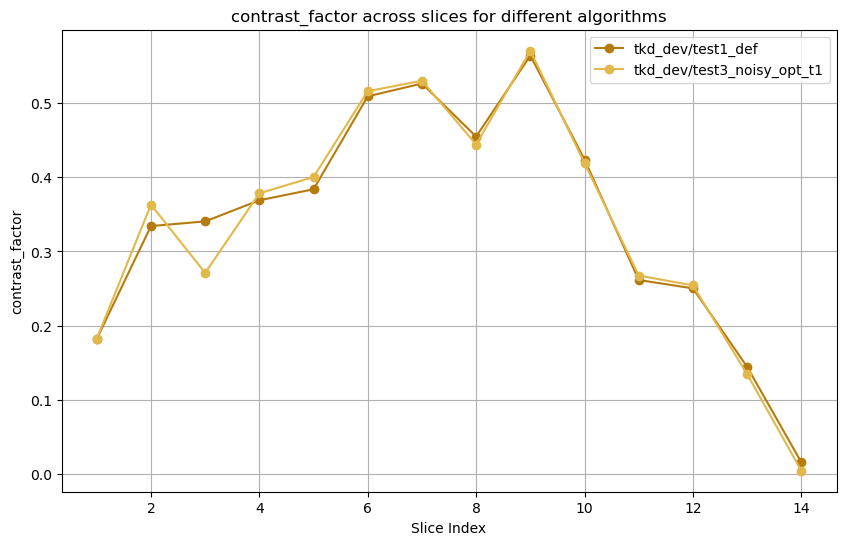

In [20]:
# Throughslice comparison for chi_003 opt pdf to all DI
# We can use the same masks, the only thing different is we want to compare algos individually

importlib.reload(monkey_tools.extract_metric)

from monkey_tools.extract_metric import single_algo_comp 

only_closedForm = [ "closed_form_dev/test1_def", "closed_form_dev/test2_noisyOpt_t1"]
only_iLSQR = ['iLSQR_dev/test1_def', 'iLSQR_dev/test3_noisyOpt_t1']
only_tkd = ['tkd_dev/test1_def', 'tkd_dev/test3_noisy_opt_t1']
only_fansi = ['FANSI_dev/weakHarmonic_OFF/test1_def', 'FANSI_dev/weakHarmonic_OFF/test2_opt']

chi_003_m2_throughslice_df = single_algo_comp('chi_003', 'm2', chi_003_m2_root_dir, only_tkd, chi_003_sc_msk_path, chi_003_m2_gm_msk_path, chi_003_m2_wm_msk_path, metric='contrast_factor')

## Phantom CNR </br>
*And more ...*</br>
Using cropped data first

In [164]:
import monkey_tools.snr_calc
importlib.reload(monkey_tools.snr_calc)

from monkey_tools.snr_calc import snr_calc  # re-import updated function

In [193]:
# Select the phantom input
phantom_input = r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\ground_truth_data\noisy\cropped\di_in_gt_ref_avg_sc_lf_Hz_snr20_crop.nii.gz"
snr = 40
cropped_gt_lf_img = nib.load(phantom_input)

In [194]:
# Let's see what contrast to noise ratio the phantom with SNR has!
cropped_wm_path = r"E:\msc_data\sc_qsm\final_gauss_sims\masks\sc_wm_crop.nii.gz"
cropped_wm_msk = nib.load(cropped_wm_path).get_fdata()
cropped_gm_path = r"E:\msc_data\sc_qsm\final_gauss_sims\masks\sc_gm_crop.nii.gz"
cropped_gm_msk = nib.load(cropped_gm_path).get_fdata()

cropped_sc_path = r"E:\msc_data\sc_qsm\final_gauss_sims\masks\only_sc_crop.nii.gz"
cropped_sc_msk = nib.load(cropped_sc_path).get_fdata()

cropped_noise_path = r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\ground_truth_data\noise_msk_crop_for_gt_lf.nii.gz"
cropped_noise_msk = nib.load(cropped_noise_path).get_fdata()

cropped_gt_lf_Hz_data = cropped_gt_lf_img.get_fdata()
signal_mean_wm_Hz = np.mean(cropped_gt_lf_Hz_data[cropped_wm_msk==1])
signal_mean_gm_Hz = np.mean(cropped_gt_lf_Hz_data[cropped_gm_msk==1])
signal_std_wm_Hz = np.std(cropped_gt_lf_Hz_data[cropped_wm_msk==1])
signal_std_gm_Hz = np.std(cropped_gt_lf_Hz_data[cropped_gm_msk==1])
contrast = np.abs(signal_mean_gm_Hz - signal_mean_wm_Hz)
pooled_std = np.sqrt((signal_std_gm_Hz**2 + signal_std_wm_Hz**2)/2)
contrast_to_noise_ratio = contrast / pooled_std

print(f"Contrast factor in cropped phantom with SNR {snr}: ", contrast)
print(f"Noise std pooled in cropped phantom with SNR {snr}: ", pooled_std)
print(f"Contrast to noise ratio in cropped phantom with SNR {snr}: ", contrast_to_noise_ratio)


Contrast factor in cropped phantom with SNR 40:  1.6771720004296904
Noise std pooled in cropped phantom with SNR 40:  0.8496552290385555
Contrast to noise ratio in cropped phantom with SNR 40:  1.973944187135208


In [195]:
phantom_snr, sigma_phantom = snr_calc(phantom_input, cropped_sc_path, cropped_noise_path)
print(f"Phantom SNR {snr} measures at: ", phantom_snr)
print("With sigma:", sigma_phantom)

Phantom SNR 40 measures at:  -220.46951022882342
With sigma: 0.0016934099008367016


In [196]:
print("STD of GM in Local Field GT: ", signal_std_gm_Hz)

STD of GM in Local Field GT:  1.0716146500278365


In [191]:
print("STD of WM in Local Field GT: ", signal_std_wm_Hz)

STD of WM in Local Field GT:  0.5435528744054717


In [192]:
print("Phantom gm mean (Hz): ", signal_mean_gm_Hz)
print("Phantom wm mean (Hz): ", signal_mean_wm_Hz)

Phantom gm mean (Hz):  0.8133728286334894
Phantom wm mean (Hz):  -0.8638903871308328


In [52]:
# For the gt chi dist :
wb_gt_chi_dist_img = nib.load(r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\ground_truth_data\bgfr_gt_ref_avg_sc_gauss_chi_dist.nii.gz")
wb_gt_chi_dist_data = wb_gt_chi_dist_img.get_fdata()

wb_gt_chi_dist_mean = np.mean(wb_gt_chi_dist_data[wb_gt_chi_dist_data != 0])
wb_gt_chi_dist_std = np.std(wb_gt_chi_dist_data[wb_gt_chi_dist_data != 0])
print("WB GT chi dist mean (ppm): ", wb_gt_chi_dist_mean)
print("WB GT chi dist std (ppm): ", wb_gt_chi_dist_std)

# Now mean for wm and gm
wb_gm_msk = nib.load(r"E:\msc_data\sc_qsm\final_gauss_sims\masks\sc_gm.nii.gz").get_fdata()
wb_wm_msk = nib.load(r"E:\msc_data\sc_qsm\final_gauss_sims\masks\sc_wm.nii.gz").get_fdata()

wb_gt_chi_dist_gm_mean = np.mean(wb_gt_chi_dist_data[wb_gm_msk==1])
wb_gt_chi_dist_wm_mean = np.mean(wb_gt_chi_dist_data[wb_wm_msk==1])

print("WB GT chi dist gm mean (ppm): ", wb_gt_chi_dist_gm_mean)
print("WB GT chi dist wm mean (ppm): ", wb_gt_chi_dist_wm_mean)


WB GT chi dist mean (ppm):  0.003550599301543012
WB GT chi dist std (ppm):  0.00024018399901473347
WB GT chi dist gm mean (ppm):  0.022868212382473243
WB GT chi dist wm mean (ppm):  -0.02983734395283352


In [54]:
# So the expected chi difference gm - wm is 
print("Expected chi difference gm - wm (ppm): ", wb_gt_chi_dist_gm_mean - wb_gt_chi_dist_wm_mean)
# or in (ppb)
print("Expected chi difference gm - wm (ppb): ", (wb_gt_chi_dist_gm_mean - wb_gt_chi_dist_wm_mean)*1000)

Expected chi difference gm - wm (ppm):  0.05270555633530676
Expected chi difference gm - wm (ppb):  52.70555633530676


In [57]:
# Let's compare before and after optimization of local field in the phantom
root_folder_phantom = r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\mrsim_outputs\custom_params_snr_100\bgfr_opt\for_wCNR_cal"
phantom_bgfr_test_folders = ['def_sharp', 'opt_sharp', 'def_lbv', 'opt_lbv', 'def_pdf', 'opt_pdf', "def_resharp", "opt_resharp", 'def_vsharp', 'opt_vsharp']
phantom_snr100_bgfr_df = multi_algo_comp_wm_gm_custom('phantom', 'snr100', 'bgfr', root_folder_phantom, phantom_bgfr_test_folders, cropped_gm_path, cropped_wm_path)


In [ ]:
wCNR_sort_phantom_snr100_bgfr_df = phantom_snr100_bgfr_df.sort_values(by='final_metric', ascending=False)
contrast_sort_phantom_snr100_bgfr_df = phantom_snr100_bgfr_df.sort_values(by='contrast_factor', ascending=False)
noise_sort_phantom_snr100_bgfr_df = phantom_snr100_bgfr_df.sort_values(by='std_denominator', ascending=True)

In [62]:
wCNR_sort_phantom_snr100_bgfr_df[['subject', 'measurement', 'test_folder', 'final_metric']]

,subject,measurement,test_folder,final_metric
5,phantom,snr100,opt_pdf,1.329519
1,phantom,snr100,opt_sharp,1.084238
7,phantom,snr100,opt_resharp,1.015620
3,phantom,snr100,opt_lbv,0.977681
4,phantom,snr100,def_pdf,0.824873
9,phantom,snr100,opt_vsharp,0.679459
2,phantom,snr100,def_lbv,0.628414
0,phantom,snr100,def_sharp,0.347300
6,phantom,snr100,def_resharp,0.346578
8,phantom,snr100,def_vsharp,0.104174


In [59]:
noise_sort_phantom_snr100_bgfr_df[['subject', 'measurement', 'test_folder', 'std_denominator']]

,subject,measurement,test_folder,std_denominator
8,phantom,snr100,def_vsharp,0.988058
6,phantom,snr100,def_resharp,1.040062
0,phantom,snr100,def_sharp,1.128568
5,phantom,snr100,opt_pdf,1.144696
7,phantom,snr100,opt_resharp,1.152777
2,phantom,snr100,def_lbv,1.199803
3,phantom,snr100,opt_lbv,1.244862
1,phantom,snr100,opt_sharp,1.247086
9,phantom,snr100,opt_vsharp,1.361128
4,phantom,snr100,def_pdf,1.840839


In [89]:
# Now same thing but with DI
phantom_di_root_folder = r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\chi_mapping_opt\for_wCNR"
phantom_di_algos = ['def_tkd','opt_tkd','def_iLSQR','opt_iLSQR','def_closed_form','opt_closed_form','def_fansi','opt_fansi','def_medi','opt_medi']

phantom_snr60_bgfr_df = multi_algo_comp_wm_gm_custom('phantom', 'snr60', 'chi_map', phantom_di_root_folder, phantom_di_algos, cropped_gm_path, cropped_wm_path)

In [90]:
wCNR_sort_phantom_snr60_bgfr_df = phantom_snr60_bgfr_df.sort_values(by='final_metric', ascending=False)
contrast_sort_phantom_snr60_bgfr_df = phantom_snr60_bgfr_df.sort_values(by='contrast_factor', ascending=False)
noise_sort_phantom_snr60_bgfr_df = phantom_snr60_bgfr_df.sort_values(by='std_denominator', ascending=True)

In [92]:
wCNR_sort_phantom_snr60_bgfr_df[['subject', 'measurement', 'test_folder', 'final_metric']]


,subject,measurement,test_folder,final_metric
4,phantom,snr60,def_closed_form,2.639416
8,phantom,snr60,def_medi,2.596216
9,phantom,snr60,opt_medi,2.325686
5,phantom,snr60,opt_closed_form,2.239734
1,phantom,snr60,opt_tkd,2.214209
0,phantom,snr60,def_tkd,2.151110
3,phantom,snr60,opt_iLSQR,2.113192
7,phantom,snr60,opt_fansi,2.083711
6,phantom,snr60,def_fansi,2.032131
2,phantom,snr60,def_iLSQR,1.814151


In [93]:
contrast_sort_phantom_snr60_bgfr_df[['subject', 'measurement', 'test_folder', 'contrast_factor']]

,subject,measurement,test_folder,contrast_factor
1,phantom,snr60,opt_tkd,0.051067
5,phantom,snr60,opt_closed_form,0.050610
6,phantom,snr60,def_fansi,0.049081
9,phantom,snr60,opt_medi,0.048458
3,phantom,snr60,opt_iLSQR,0.047739
0,phantom,snr60,def_tkd,0.046286
7,phantom,snr60,opt_fansi,0.045498
4,phantom,snr60,def_closed_form,0.030826
8,phantom,snr60,def_medi,0.030790
2,phantom,snr60,def_iLSQR,0.028585


In [96]:
noise_sort_phantom_snr60_bgfr_df[['subject', 'measurement', 'test_folder', 'std_gm', 'std_wm', 'std_denominator']]

,subject,measurement,test_folder,std_gm,std_wm,std_denominator
4,phantom,snr60,def_closed_form,0.014446,0.008007,0.011679
8,phantom,snr60,def_medi,0.015261,0.006958,0.011859
2,phantom,snr60,def_iLSQR,0.018981,0.011674,0.015757
9,phantom,snr60,opt_medi,0.028154,0.008696,0.020836
0,phantom,snr60,def_tkd,0.028025,0.011856,0.021517
7,phantom,snr60,opt_fansi,0.029018,0.010561,0.021835
3,phantom,snr60,opt_iLSQR,0.029681,0.011822,0.022591
5,phantom,snr60,opt_closed_form,0.030236,0.010344,0.022596
1,phantom,snr60,opt_tkd,0.030891,0.010468,0.023063
6,phantom,snr60,def_fansi,0.031115,0.014091,0.024153


In [70]:
# Let's try to calculate the HFEN and see if this shows what we see in the data above:
# We need the GT chi map:
gt_chimap_avg_sc_data = nib.load(r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\ground_truth_data\di_gt_ref_avg_sc_gauss_chi_dist_crop.nii.gz").get_fdata()
# Let's calculate some useful metrics
gt_wm_mean = np.mean(gt_chimap_avg_sc_data[cropped_wm_msk==1])
gt_gm_mean = np.mean(gt_chimap_avg_sc_data[cropped_gm_msk==1])

print(f"On the phantom's GT chi, GM mean: {gt_gm_mean} and WM mean: {gt_wm_mean}")


On the phantom's GT chi, GM mean: 0.022426660975986203 and WM mean: -0.02965111181133505


In [83]:
# Remember the dims
gt_chimap_avg_sc_data.shape

(301, 351, 128)

### HFEN test

In [84]:
from scipy.ndimage import convolve
def compute_rmse(im_data1, im_data2, mask = None):
    diff = im_data1 - im_data2
    if mask is not None:
        diff = diff[mask==1]

    return np.sqrt(np.mean(diff**2))

def compute_hfen(im_data1, im_data2, mask = None):
    filt_size = np.array([11,11,5])
    sigma = np.array([1.5,1.5,0.6])

    siz = (filt_size-1)//2

    # Create the grid
    x, y, z = np.meshgrid(
        np.arange(-siz[0], siz[0] + 1),
        np.arange(-siz[1], siz[1] + 1),
        np.arange(-siz[2], siz[2] + 1),
        indexing="ij"
    )

    h = np.exp(
        -(x**2 / (2 * sigma[0]**2)
        + y**2 / (2 * sigma[1]**2)
        + z**2 / (2 * sigma[2]**2))
    )
    h /= np.sum(h)

    arg = (
        x**2 / sigma[0]**4
        + y**2 / sigma[1]**4
        + z**2 / sigma[2]**4
        - (1 / sigma[0]**2 + 1 / sigma[1]**2 + 1 / sigma[2]**2)
    )

    H = arg * h
    H -= np.mean(H)

    im1_log = convolve(im_data1, H, mode='nearest')
    im2_log = convolve(im_data2, H, mode='nearest')

    hfen = compute_rmse(im1_log, im2_log, mask)
    return hfen



In [72]:
# Now let/s create the before and after for TKD
before_TKD_chimap =  nib.load(r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\chi_mapping_opt\for_wCNR\def_tkd\Sepia_Chimap.nii.gz").get_fdata()
after_TKD_chmap = nib.load(r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\chi_mapping_opt\for_wCNR\opt_tkd\Sepia_Chimap.nii.gz").get_fdata()

In [80]:
before_closedForm_chimap = nib.load(r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\chi_mapping_opt\for_wCNR\def_closed_form\Sepia_Chimap.nii.gz").get_fdata()
after_closedForm_chimap = nib.load(r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\chi_mapping_opt\for_wCNR\opt_closed_form\Sepia_Chimap.nii.gz").get_fdata()


In [87]:
invivo_before_closedForm = nib.load(r"E:\msc_data\sc_qsm\neuropoly_data\chi_003\qsm_processing\2nd_3D_meGRE\chi_map\closed_form_dev\test1_def\Sepia_Chimap.nii.gz").get_fdata()
invivo_after_closedForm = nib.load(r"E:\msc_data\sc_qsm\neuropoly_data\chi_003\qsm_processing\2nd_3D_meGRE\chi_map\closed_form_dev\test2_noisyOpt_t1\Sepia_Chimap.nii.gz").get_fdata()

In [85]:
hfen_before = compute_hfen(before_closedForm_chimap, gt_chimap_avg_sc_data, mask = cropped_sc_msk)
hfen_after = compute_hfen(after_closedForm_chimap, gt_chimap_avg_sc_data, mask = cropped_sc_msk)

print(f"HFEN before: {hfen_before:.4e}")
print(f"HFEN after : {hfen_after:.4e}")

HFEN before: 8.5201e-03
HFEN after : 6.2865e-03


In [86]:
hfen_after - hfen_before

np.float64(-0.0022336257130521125)

## chi_004

### <span style="color:#3FC2E0"> DI </span> </br>

In [264]:
chi_004_m2_test_folders = di_comp_vector
# Remove MEDI due to wrong mean calculation, something wrong with lambda in MEDI 'MEDI_dev/test1_def', 'MEDI_dev/test6_noSMV_lmbda1e5'
chi_004_m2_root_dir =  r"E:\msc_data\sc_qsm\neuropoly_data\chi_004\qsm_processing\m2\auto_di_comp\comp_di"
chi_004_sc_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_004\qsm_processing\m2\chi_004_m2_sc_msk.nii.gz"
chi_004_m2_gm_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_004\qsm_processing\m2\chi_004_m2_gm_msk.nii.gz"
chi_004_m2_wm_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_004\qsm_processing\m2\chi_004_m2_wm_msk.nii.gz"
chi_004_m2_opt_pdf_to_all_DI_df = multi_algo_comp_wm_gm_custom('chi_004', 'm2', "chi_map",chi_004_m2_root_dir, chi_004_m2_test_folders, chi_004_m2_gm_msk_path, chi_004_m2_wm_msk_path)

In [265]:
contrast_sorted_chi_004_m2 = chi_004_m2_opt_pdf_to_all_DI_df.sort_values(by='contrast_factor', ascending=False)
noise_sorted_chi_004_m2 = chi_004_m2_opt_pdf_to_all_DI_df.sort_values(by='std_denominator', ascending=True)
final_metric_sorted_chi_004_m2 = chi_004_m2_opt_pdf_to_all_DI_df.sort_values(by='final_metric', ascending=False)

In [273]:
final_metric_sorted_chi_004_m2[['subject', 'measurement', 'test_folder', 'mean_gm', "std_gm",'mean_wm',"std_wm", 'final_metric']]

,subject,measurement,test_folder,mean_gm,std_gm,mean_wm,std_wm,final_metric
7,chi_004,m2,auto_closedForm,0.008408,0.009299,-0.001475,0.005488,1.294380
4,chi_004,m2,auto_iLSQR,0.008700,0.009618,-0.001526,0.006297,1.258044
5,chi_004,m2,def_closedForm,0.009450,0.010730,-0.001658,0.006475,1.253499
2,chi_004,m2,def_iLSQR,0.010242,0.011389,-0.001797,0.007697,1.238536
9,chi_004,m2,opt_fansi,0.005655,0.007489,-0.000992,0.002933,1.168825
3,chi_004,m2,opt_iLSQR,0.012346,0.015540,-0.002166,0.010124,1.106561
0,chi_004,m2,def_tkd,0.012307,0.015539,-0.002159,0.010092,1.104100
8,chi_004,m2,def_fansi,0.012046,0.015342,-0.002113,0.009806,1.099762
6,chi_004,m2,opt_closedForm,0.012274,0.015636,-0.002153,0.010066,1.097186
1,chi_004,m2,opt_tkd,0.012301,0.015686,-0.002158,0.010119,1.095435


In [270]:
noise_sorted_chi_004_m2[['subject', 'measurement', 'test_folder', 'std_gm','std_wm','raw_metric', 'std_denominator']]

,subject,measurement,test_folder,std_gm,std_wm,raw_metric,std_denominator
9,chi_004,m2,opt_fansi,0.007489,0.002933,1.168825,0.005687
7,chi_004,m2,auto_closedForm,0.009299,0.005488,1.294380,0.007635
4,chi_004,m2,auto_iLSQR,0.009618,0.006297,1.258044,0.008129
5,chi_004,m2,def_closedForm,0.010730,0.006475,1.253499,0.008861
2,chi_004,m2,def_iLSQR,0.011389,0.007697,1.238536,0.009720
8,chi_004,m2,def_fansi,0.015342,0.009806,1.099762,0.012875
0,chi_004,m2,def_tkd,0.015539,0.010092,1.104100,0.013102
3,chi_004,m2,opt_iLSQR,0.015540,0.010124,1.106561,0.013115
6,chi_004,m2,opt_closedForm,0.015636,0.010066,1.097186,0.013149
1,chi_004,m2,opt_tkd,0.015686,0.010119,1.095435,0.013199


In [268]:
contrast_sorted_chi_004_m2[['subject', 'measurement', 'test_folder', 'gm_penality','wm_penality','raw_metric', 'contrast_factor']]

,subject,measurement,test_folder,gm_penality,wm_penality,raw_metric,contrast_factor
3,chi_004,m2,opt_iLSQR,1.0,1.0,1.106561,0.014512
0,chi_004,m2,def_tkd,1.0,1.0,1.104100,0.014466
1,chi_004,m2,opt_tkd,1.0,1.0,1.095435,0.014459
6,chi_004,m2,opt_closedForm,1.0,1.0,1.097186,0.014427
8,chi_004,m2,def_fansi,1.0,1.0,1.099762,0.014160
2,chi_004,m2,def_iLSQR,1.0,1.0,1.238536,0.012039
5,chi_004,m2,def_closedForm,1.0,1.0,1.253499,0.011108
4,chi_004,m2,auto_iLSQR,1.0,1.0,1.258044,0.010226
7,chi_004,m2,auto_closedForm,1.0,1.0,1.294380,0.009883
9,chi_004,m2,opt_fansi,1.0,1.0,1.168825,0.006647


### <span style="color:#E03F6B"> BGFR </span> </br>

In [244]:
# For BGFR
chi_004_bgfr_root = r"E:\msc_data\sc_qsm\neuropoly_data\chi_004\qsm_processing\m2\auto_bgfr_comp\comp_bgfr"
chi_004_m2_BGFR_test_folders = ['def_pdf', 'opt_pdf', 'def_lbv', 'opt_lbv','opt_resharp', 'opt_sharp']

chi_004_m2_bgfr_df = multi_algo_comp_wm_gm_custom('chi_004', 'm2', 'bgfr', chi_004_bgfr_root, chi_004_m2_BGFR_test_folders, chi_004_m2_gm_msk_path, chi_004_m2_wm_msk_path)

In [245]:
final_metric_sorted_chi_004_m2_bgfr = chi_004_m2_bgfr_df.sort_values(by='final_metric', ascending=False)
contrast_sorted_chi_004_m2_bgfr = chi_004_m2_bgfr_df.sort_values(by="contrast_factor", ascending=False)
noise_sorted_chi_004_m2_bgfr = chi_004_m2_bgfr_df.sort_values(by="std_denominator", ascending = True)

In [263]:
final_metric_sorted_chi_004_m2_bgfr[['subject', 'test_folder', 'std_gm', 'std_wm', "gm_penality", "wm_penality", 'raw_metric', 'final_metric']]

,subject,test_folder,std_gm,std_wm,gm_penality,wm_penality,raw_metric,final_metric
0,chi_004,def_pdf,0.700552,0.550979,1.000000,1.000000,1.263878,1.263878
1,chi_004,opt_pdf,0.635359,0.412866,1.000000,1.000000,1.078979,1.078979
5,chi_004,opt_sharp,0.771800,0.571374,0.986747,0.576622,1.148545,0.653499
4,chi_004,opt_resharp,0.468016,0.342866,0.986747,0.576622,0.877369,0.499206
3,chi_004,opt_lbv,0.533985,0.302876,0.531325,0.210104,1.711301,0.191038
2,chi_004,def_lbv,0.253137,0.156511,0.134940,0.050729,3.793752,0.025970


In [247]:
contrast_sorted_chi_004_m2_bgfr[['subject', 'measurement', 'mean_gm', 'mean_wm', 'test_folder', "contrast_factor", 'raw_metric']]

,subject,measurement,mean_gm,mean_wm,test_folder,contrast_factor,raw_metric
2,chi_004,m2,0.462130,-0.336246,def_lbv,0.798376,3.793752
0,chi_004,m2,0.677910,-0.118610,def_pdf,0.796520,1.263878
5,chi_004,m2,0.722595,-0.057293,opt_sharp,0.779887,1.148545
3,chi_004,m2,0.531432,-0.211433,opt_lbv,0.742865,1.711301
1,chi_004,m2,0.492853,-0.085251,opt_pdf,0.578105,1.078979
4,chi_004,m2,0.291912,-0.068021,opt_resharp,0.359933,0.877369


In [248]:
noise_sorted_chi_004_m2_bgfr[['subject', 'measurement', 'mean_gm', 'mean_wm', 'test_folder', 'std_denominator']]

,subject,measurement,mean_gm,mean_wm,test_folder,std_denominator
2,chi_004,m2,0.462130,-0.336246,def_lbv,0.210445
4,chi_004,m2,0.291912,-0.068021,opt_resharp,0.410241
3,chi_004,m2,0.531432,-0.211433,opt_lbv,0.434094
1,chi_004,m2,0.492853,-0.085251,opt_pdf,0.535789
0,chi_004,m2,0.677910,-0.118610,def_pdf,0.630219
5,chi_004,m2,0.722595,-0.057293,opt_sharp,0.679022


## chi_005

In [ ]:
chi_005_sc_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_005\qsm_processing\chi_005_sc_msk.nii.gz"
chi_005_gm_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_005\qsm_processing\chi_005_gm_msk.nii.gz"
chi_005_wm_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_005\qsm_processing\chi_005_wm_msk.nii.gz"

### <span style="color:#3FC2E0"> DI </span> </br>

In [292]:
chi_005_test_folders = di_comp_vector
# Remove MEDI due to wrong mean calculation, something wrong with lambda in MEDI 'MEDI_dev/test1_def', 'MEDI_dev/test6_noSMV_lmbda1e5'
chi_005_root_dir =  r"E:\msc_data\sc_qsm\neuropoly_data\chi_005\qsm_processing\auto_di_comp\comp_di"

chi_005_opt_pdf_to_all_DI_df = multi_algo_comp_wm_gm_custom('chi_005', 'm1', "chi_map", chi_005_root_dir, chi_005_test_folders, chi_005_gm_msk_path, chi_005_wm_msk_path)

In [293]:
final_metric_sorted_chi_005_opt_pdf_to_all_DI_df = chi_005_opt_pdf_to_all_DI_df.sort_values(by='final_metric', ascending=False)
contrast_sorted_chi_005_opt_pdf_to_all_DI_df = chi_005_opt_pdf_to_all_DI_df.sort_values(by="contrast_factor", ascending=False)
noise_sorted_chi_005_opt_pdf_to_all_DI_df = chi_005_opt_pdf_to_all_DI_df.sort_values(by="std_denominator", ascending = True)

In [295]:
final_metric_sorted_chi_005_opt_pdf_to_all_DI_df[['subject', 'test_folder', 'mean_gm', 'std_gm', 'mean_wm','std_wm', 'raw_metric', 'final_metric']]

,subject,test_folder,mean_gm,std_gm,mean_wm,std_wm,raw_metric,final_metric
4,chi_005,auto_iLSQR,0.019437,0.013366,-0.003607,0.013275,1.729919,1.729919
7,chi_005,auto_closedForm,0.018096,0.013740,-0.003440,0.011301,1.711958,1.711958
5,chi_005,def_closedForm,0.019917,0.015525,-0.003799,0.012789,1.667465,1.667465
2,chi_005,def_iLSQR,0.021843,0.015915,-0.003117,0.015653,1.581287,1.581287
9,chi_005,opt_fansi,0.016659,0.014653,-0.002837,0.009890,1.559616,1.559616
0,chi_005,def_tkd,0.023310,0.019782,-0.004496,0.016985,1.508172,1.508172
3,chi_005,opt_iLSQR,0.023360,0.019772,-0.004538,0.017357,1.499623,1.499623
8,chi_005,def_fansi,0.023073,0.019744,-0.004493,0.017065,1.493866,1.493866
6,chi_005,opt_closedForm,0.023296,0.020542,-0.004457,0.017268,1.462602,1.462602
1,chi_005,opt_tkd,0.023323,0.020556,-0.004471,0.017342,1.461555,1.461555


In [296]:
contrast_sorted_chi_005_opt_pdf_to_all_DI_df[['subject', 'measurement', 'mean_gm', 'mean_wm', 'test_folder', "contrast_factor", 'raw_metric']]

,subject,measurement,mean_gm,mean_wm,test_folder,contrast_factor,raw_metric
3,chi_005,m1,0.023360,-0.004538,opt_iLSQR,0.027899,1.499623
0,chi_005,m1,0.023310,-0.004496,def_tkd,0.027806,1.508172
1,chi_005,m1,0.023323,-0.004471,opt_tkd,0.027794,1.461555
6,chi_005,m1,0.023296,-0.004457,opt_closedForm,0.027754,1.462602
8,chi_005,m1,0.023073,-0.004493,def_fansi,0.027567,1.493866
2,chi_005,m1,0.021843,-0.003117,def_iLSQR,0.024960,1.581287
5,chi_005,m1,0.019917,-0.003799,def_closedForm,0.023716,1.667465
4,chi_005,m1,0.019437,-0.003607,auto_iLSQR,0.023044,1.729919
7,chi_005,m1,0.018096,-0.003440,auto_closedForm,0.021536,1.711958
9,chi_005,m1,0.016659,-0.002837,opt_fansi,0.019496,1.559616


In [281]:
noise_sorted_chi_005_opt_pdf_to_all_DI_df[['subject', 'measurement', 'mean_gm', 'mean_wm', 'test_folder', 'std_denominator']]

,subject,measurement,mean_gm,mean_wm,test_folder,std_denominator
9,chi_005,m1,0.016659,-0.002837,opt_fansi,0.012501
7,chi_005,m1,0.018096,-0.003440,auto_closedForm,0.012580
4,chi_005,m1,0.019437,-0.003607,auto_iLSQR,0.013321
5,chi_005,m1,0.019917,-0.003799,def_closedForm,0.014223
2,chi_005,m1,0.021843,-0.003117,def_iLSQR,0.015785
0,chi_005,m1,0.023310,-0.004496,def_tkd,0.018437
8,chi_005,m1,0.023073,-0.004493,def_fansi,0.018453
3,chi_005,m1,0.023360,-0.004538,opt_iLSQR,0.018604
6,chi_005,m1,0.023296,-0.004457,opt_closedForm,0.018976
1,chi_005,m1,0.023323,-0.004471,opt_tkd,0.019017


### <span style="color:#E03F6B"> BGFR </span> </br>


In [286]:
# For BGFR
chi_005_bgfr_root = r"E:\msc_data\sc_qsm\neuropoly_data\chi_005\qsm_processing\auto_bgfr_comp\comp_bgfr"
chi_005_BGFR_test_folders = ['def_pdf', 'opt_pdf', 'def_lbv', 'opt_lbv','opt_resharp', 'opt_sharp']

chi_005_bgfr_df = multi_algo_comp_wm_gm_custom('chi_005', 'm1', 'bgfr', chi_005_bgfr_root, chi_005_BGFR_test_folders, chi_005_gm_msk_path, chi_005_wm_msk_path)

In [242]:
final_metric_sorted_chi_005_bgfr_df = chi_005_bgfr_df.sort_values(by='final_metric', ascending=False)
contrast_sorted_chi_005_bgfr_df = chi_005_bgfr_df.sort_values(by="contrast_factor", ascending=False)
noise_sorted_chi_005_bgfr_df = chi_005_bgfr_df.sort_values(by="std_denominator", ascending = True)

In [149]:
final_metric_sorted_chi_005_bgfr_df[['subject', 'test_folder', 'std_gm', 'std_wm', "gm_penality", "wm_penality", 'raw_metric', 'final_metric']]

,subject,test_folder,std_gm,std_wm,gm_penality,wm_penality,raw_metric,final_metric
0,chi_005,pdf_def,0.866047,0.882003,1.000000,1.000000,1.518323,1.518323
1,chi_005,pdf_opt,0.856036,0.744752,1.000000,1.000000,1.495103,1.495103
4,chi_005,resharp_def,0.650662,0.452181,0.983815,0.568728,1.308825,0.732317
6,chi_005,sharp_opt,0.680265,0.472605,0.983815,0.568728,1.248280,0.698441
5,chi_005,resharp_opt,0.602906,0.426950,0.983815,0.568728,1.201047,0.672013
2,chi_005,lbv_def,0.975868,0.394004,0.456647,0.220418,1.462180,0.147173
3,chi_005,lbv_def,0.975868,0.394004,0.456647,0.220418,1.462180,0.147173


In [243]:
final_metric_sorted_chi_005_bgfr_df[['subject', 'test_folder', 'std_gm', 'std_wm', "gm_penality", "wm_penality", 'raw_metric', 'final_metric']]

,subject,test_folder,std_gm,std_wm,gm_penality,wm_penality,raw_metric,final_metric
0,chi_005,def_pdf,0.822559,0.827545,1.000000,1.000000,1.545953,1.545953
1,chi_005,opt_pdf,0.814801,0.698561,1.000000,1.000000,1.520963,1.520963
5,chi_005,opt_sharp,0.813694,0.613948,0.983815,0.568728,1.211019,0.677593
4,chi_005,opt_resharp,0.476623,0.346915,0.983815,0.568728,1.025733,0.573921
3,chi_005,opt_lbv,1.139944,0.605550,0.687861,0.405249,1.172307,0.326787
2,chi_005,def_lbv,0.936679,0.372088,0.456647,0.220418,1.477232,0.148688


In [159]:
contrast_sorted_chi_005_bgfr_df[['subject', 'measurement', 'mean_gm', 'mean_wm', 'test_folder', "contrast_factor", 'raw_metric']]

,subject,measurement,mean_gm,mean_wm,test_folder,contrast_factor,raw_metric
0,chi_005,m1,1.114003,-0.213105,pdf_def,1.327108,1.518323
1,chi_005,m1,1.005842,-0.193717,pdf_opt,1.199559,1.495103
2,chi_005,m1,1.511641,0.423540,lbv_def,1.088101,1.462180
3,chi_005,m1,1.511641,0.423540,lbv_def,1.088101,1.462180
4,chi_005,m1,0.689884,-0.043425,resharp_def,0.733309,1.308825
6,chi_005,m1,0.584152,-0.146980,sharp_opt,0.731132,1.248280
5,chi_005,m1,0.550464,-0.076950,resharp_opt,0.627414,1.201047


In [160]:
noise_sorted_chi_005_bgfr_df[['subject', 'measurement', 'mean_gm', 'mean_wm', 'test_folder', 'std_denominator']]

,subject,measurement,mean_gm,mean_wm,test_folder,std_denominator
5,chi_005,m1,0.550464,-0.076950,resharp_opt,0.522389
4,chi_005,m1,0.689884,-0.043425,resharp_def,0.560280
6,chi_005,m1,0.584152,-0.146980,sharp_opt,0.585711
3,chi_005,m1,1.511641,0.423540,lbv_def,0.744163
2,chi_005,m1,1.511641,0.423540,lbv_def,0.744163
1,chi_005,m1,1.005842,-0.193717,pdf_opt,0.802326
0,chi_005,m1,1.114003,-0.213105,pdf_def,0.874061


## chi_006

In [283]:
chi_006_m3_sc_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_006\qsm_processing\chi_006_m3_sc_msk.nii.gz"
chi_006_m3_gm_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_006\qsm_processing\chi_006_m3_gm_msk.nii.gz"
chi_006_m3_wm_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_006\qsm_processing\chi_006_m3_wm_msk.nii.gz"

### <span style="color:#E03F6B"> BGFR </span> </br>


In [285]:
# For BGFR
chi_006_bgfr_root = r"E:\msc_data\sc_qsm\neuropoly_data\chi_006\qsm_processing\auto_bgfr_comp\comp_bgfr"
chi_006_BGFR_test_folders = bgfr_comp_vector

chi_006_bgfr_df = multi_algo_comp_wm_gm_custom('chi_006', 'm3', 'bgfr', chi_006_bgfr_root, chi_006_BGFR_test_folders, chi_006_m3_gm_msk_path, chi_006_m3_wm_msk_path)

In [287]:
final_metric_sorted_chi_006_bgfr_df = chi_006_bgfr_df.sort_values(by='final_metric', ascending=False)
contrast_sorted_chi_006_bgfr_df = chi_006_bgfr_df.sort_values(by="contrast_factor", ascending=False)
noise_sorted_chi_006_bgfr_df = chi_006_bgfr_df.sort_values(by="std_denominator", ascending = True)

In [290]:
final_metric_sorted_chi_006_bgfr_df[['subject', 'test_folder', 'std_gm', 'std_wm', "mean_gm", "mean_wm", 'raw_metric', 'final_metric']]

,subject,test_folder,std_gm,std_wm,mean_gm,mean_wm,raw_metric,final_metric
0,chi_006,def_pdf,0.527351,0.463408,0.439071,-0.093862,1.073572,0.982275
1,chi_006,opt_pdf,0.464923,0.295409,0.331449,-0.069643,1.029762,0.942190
4,chi_006,opt_sharp,0.686985,0.530927,0.559332,-0.082237,1.045013,0.518318
5,chi_006,opt_resharp,0.310930,0.225752,0.202628,-0.066565,0.990776,0.491417
3,chi_006,opt_lbv,0.415327,0.216595,0.406842,-0.014643,1.272534,0.099599
2,chi_006,def_lbv,0.090566,0.085554,0.057883,-0.228803,3.254261,0.010913


### <span style="color:#3FC2E0"> DI </span> </br>

In [311]:
chi_006_di_test_folders = di_comp_vector
# Remove MEDI due to wrong mean calculation, something wrong with lambda in MEDI 'MEDI_dev/test1_def', 'MEDI_dev/test6_noSMV_lmbda1e5'
chi_006_root_dir =  r"E:\msc_data\sc_qsm\neuropoly_data\chi_006\qsm_processing\auto_di_comp\comp_di"

chi_006_opt_pdf_to_all_DI_df = multi_algo_comp_wm_gm_custom('chi_006', 'm3', "chi_map", chi_006_root_dir, chi_006_di_test_folders, chi_006_m3_gm_msk_path, chi_006_m3_wm_msk_path)

In [299]:
final_metric_sorted_chi_006_opt_pdf_to_all_DI_df = chi_006_opt_pdf_to_all_DI_df.sort_values(by='final_metric', ascending=False)
contrast_sorted_chi_006_opt_pdf_to_all_DI_df = chi_006_opt_pdf_to_all_DI_df.sort_values(by="contrast_factor", ascending=False)
noise_sorted_chi_006_opt_pdf_to_all_DI_df = chi_006_opt_pdf_to_all_DI_df.sort_values(by="std_denominator", ascending = True)

In [301]:
final_metric_sorted_chi_006_opt_pdf_to_all_DI_df[['subject', 'test_folder', 'std_gm', 'std_wm', "mean_gm", "mean_wm", 'raw_metric', 'final_metric']]

,subject,test_folder,std_gm,std_wm,mean_gm,mean_wm,raw_metric,final_metric
7,chi_006,auto_closedForm,0.000885,0.001087,0.001434,-0.000473,1.925103,0.022731
5,chi_006,def_closedForm,0.001035,0.001310,0.001606,-0.000517,1.798415,0.021235
4,chi_006,auto_iLSQR,0.000851,0.001091,0.001721,0.000033,1.724835,0.020366
2,chi_006,def_iLSQR,0.000960,0.001241,0.001602,-0.000194,1.618877,0.019115
8,chi_006,def_fansi,0.001475,0.001995,0.001892,-0.000623,1.433206,0.016923
0,chi_006,def_tkd,0.001586,0.002112,0.002077,-0.000582,1.423812,0.016812
3,chi_006,opt_iLSQR,0.001546,0.002096,0.001961,-0.000611,1.396331,0.016488
1,chi_006,opt_tkd,0.001579,0.002129,0.001979,-0.000630,1.391948,0.016436
6,chi_006,opt_closedForm,0.001571,0.002115,0.001947,-0.000645,1.390942,0.016424
9,chi_006,opt_fansi,0.000003,0.000004,-0.000010,-0.000009,0.094737,0.001119


## chi_007

In [302]:
chi_007_m1_sc_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_007\qsm_processing\chi_007_m1_sc_msk.nii.gz"
chi_007_m1_gm_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_007\qsm_processing\chi_007_m1_gm_msk.nii.gz"
chi_007_m1_wm_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_007\qsm_processing\chi_007_m1_wm_msk.nii.gz"

### <span style="color:#E03F6B"> BGFR </span> </br>

In [306]:
# For BGFR
chi_007_bgfr_root = r"E:\msc_data\sc_qsm\neuropoly_data\chi_007\qsm_processing\auto_bgfr_comp\comp_bgfr"
chi_007_BGFR_test_folders = bgfr_comp_vector

chi_007_bgfr_df = multi_algo_comp_wm_gm_custom('chi_007', 'm1', 'bgfr', chi_007_bgfr_root, chi_007_BGFR_test_folders, chi_007_m1_gm_msk_path, chi_007_m1_wm_msk_path)

In [307]:
final_metric_sorted_chi_007_bgfr_df = chi_007_bgfr_df.sort_values(by='final_metric', ascending=False)
contrast_sorted_chi_007_bgfr_df = chi_007_bgfr_df.sort_values(by="contrast_factor", ascending=False)
noise_sorted_chi_007_bgfr_df = chi_007_bgfr_df.sort_values(by="std_denominator", ascending = True)

In [308]:
final_metric_sorted_chi_007_bgfr_df[['subject', 'test_folder', 'std_gm', 'std_wm', "mean_gm", "mean_wm", 'raw_metric', 'final_metric']]

,subject,test_folder,std_gm,std_wm,mean_gm,mean_wm,raw_metric,final_metric
1,chi_007,opt_pdf,0.569904,0.400859,0.482053,-0.083565,1.148031,1.148031
0,chi_007,def_pdf,0.596191,0.534357,0.529189,-0.092077,1.097413,1.097413
4,chi_007,opt_sharp,0.691019,0.543577,0.653762,-0.092118,1.199773,0.647869
5,chi_007,opt_resharp,0.406178,0.276834,0.277868,-0.079621,1.028523,0.555395
3,chi_007,opt_lbv,0.599288,0.348895,0.744420,-0.052993,1.626233,0.265564
2,chi_007,def_lbv,0.439220,0.224371,0.682002,-0.153835,2.396650,0.089244


### <span style="color:#3FC2E0"> DI </span> </br>

In [315]:
chi_007_di_test_folders = di_comp_vector
# Remove MEDI due to wrong mean calculation, something wrong with lambda in MEDI 'MEDI_dev/test1_def', 'MEDI_dev/test6_noSMV_lmbda1e5'
chi_007_root_dir =  r"E:\msc_data\sc_qsm\neuropoly_data\chi_007\qsm_processing\auto_di_comp\comp_di"

chi_007_opt_pdf_to_all_DI_df = multi_algo_comp_wm_gm_custom('chi_007', 'm1', "chi_map", chi_007_root_dir, chi_007_di_test_folders, chi_007_m1_gm_msk_path, chi_007_m1_wm_msk_path)

In [316]:
final_metric_sorted_chi_007_opt_pdf_to_all_DI_df = chi_007_opt_pdf_to_all_DI_df.sort_values(by='final_metric', ascending=False)
contrast_sorted_chi_007_opt_pdf_to_all_DI_df = chi_007_opt_pdf_to_all_DI_df.sort_values(by="contrast_factor", ascending=False)
noise_sorted_chi_007_opt_pdf_to_all_DI_df = chi_007_opt_pdf_to_all_DI_df.sort_values(by="std_denominator", ascending = True)

In [317]:
final_metric_sorted_chi_007_opt_pdf_to_all_DI_df[['subject', 'test_folder', 'std_gm', 'std_wm', "mean_gm", "mean_wm", 'raw_metric', 'final_metric']]

,subject,test_folder,std_gm,std_wm,mean_gm,mean_wm,raw_metric,final_metric
4,chi_007,auto_iLSQR,0.008956,0.006305,0.008966,-0.001552,1.357965,1.357965
7,chi_007,auto_closedForm,0.009077,0.005649,0.008602,-0.001489,1.334755,1.334755
2,chi_007,def_iLSQR,0.010498,0.007356,0.010224,-0.001769,1.323108,1.323108
5,chi_007,def_closedForm,0.010428,0.006694,0.009639,-0.001668,1.290454,1.290454
9,chi_007,opt_fansi,0.007804,0.003342,0.006089,-0.001054,1.189933,1.189933
8,chi_007,def_fansi,0.013568,0.009540,0.011446,-0.001981,1.144833,1.144833
0,chi_007,def_tkd,0.013736,0.009695,0.011595,-0.002007,1.144097,1.144097
3,chi_007,opt_iLSQR,0.013777,0.009820,0.011567,-0.002002,1.134199,1.134199
6,chi_007,opt_closedForm,0.013811,0.009793,0.011559,-0.002000,1.132607,1.132607
1,chi_007,opt_tkd,0.013851,0.009838,0.011579,-0.002004,1.130659,1.130659


## chi_008

### <span style="color:#3FC2E0"> DI </span> </br>

In [109]:
chi_008_test_folders = ['tkd_def', 'tkd_opt', 'iLSQR_def', 'iLSQR_opt', "closedForm_def","closedForm_opt", "closedForm_auto"]
chi_008_root_dir = r"E:\msc_data\sc_qsm\neuropoly_data\chi_008\qsm_processing\chi_map"
chi_008_sc_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_008\qsm_processing\chi_008_sc_msk.nii.gz"
chi_008_gm_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_008\qsm_processing\chi_008_gm_msk.nii.gz"
chi_008_wm_msk_path = r"E:\msc_data\sc_qsm\neuropoly_data\chi_008\qsm_processing\chi_008_wm_msk.nii.gz"
chi_008_opt_pdf_to_all_DI_df = multi_algo_comp_wm_gm_custom('chi_008', 'm1', "chi_map", chi_008_root_dir, chi_008_test_folders, chi_008_gm_msk_path, chi_008_wm_msk_path)


chi_map resulting map not found for tkd_opt, skipping...
chi_map resulting map not found for iLSQR_def, skipping...
chi_map resulting map not found for iLSQR_opt, skipping...
chi_map resulting map not found for closedForm_def, skipping...
chi_map resulting map not found for closedForm_opt, skipping...
chi_map resulting map not found for closedForm_auto, skipping...


In [110]:
chi_008_opt_pdf_to_all_DI_df

,subject,measurement,test_folder,mean_gm,std_gm,total_vox_gm,nonzero_vox_gm,gm_penality,mean_wm,std_wm,total_vox_wm,nonzero_vox_wm,wm_penality,contrast_factor,std_denominator,raw_metric,final_metric
0,chi_008,m1,tkd_def,0.006765,0.014703,800,783,0.97875,-0.001264,0.011588,4198,4197,0.999762,0.008029,0.013237,0.606572,0.593541


In [111]:
# Let's see gm and wm mean + std
chi_008_opt_pdf_to_all_DI_df[['subject', 'mean_gm', 'std_gm', 'gm_penality','mean_wm','std_wm', 'wm_penality']]

,subject,mean_gm,std_gm,gm_penality,mean_wm,std_wm,wm_penality
0,chi_008,0.006765,0.014703,0.97875,-0.001264,0.011588,0.999762


### <span style="color:#E03F6B"> BGFR </span> </br>

In [135]:
# For BGFR
chi_008_bgfr_root = r"E:\msc_data\sc_qsm\neuropoly_data\chi_008\qsm_processing\local_field"
chi_008_BGFR_test_folders = ['pdf_def', 'pdf_opt', 'lbv_def', 'lbv_opt','resharp_def', 'resharp_opt', 'sharp_opt']

chi_008_bgfr_df = multi_algo_comp_wm_gm_custom('chi_008', 'm1', 'bgfr', chi_008_bgfr_root, chi_008_BGFR_test_folders, chi_008_gm_msk_path, chi_008_wm_msk_path)

In [161]:
final_metric_sorted_chi_008_bgfr_df = chi_008_bgfr_df.sort_values(by='final_metric', ascending=False)
contrast_sorted_chi_008_bgfr_df= chi_008_bgfr_df.sort_values(by="contrast_factor", ascending=False)
noise_sorted_chi_008_bgfr_df = chi_008_bgfr_df.sort_values(by="std_denominator", ascending = True)

In [150]:
final_metric_sorted_chi_008_bgfr_df[['subject', 'test_folder', 'std_gm', 'std_wm', "gm_penality", "wm_penality", 'raw_metric', 'final_metric']]

,subject,test_folder,std_gm,std_wm,gm_penality,wm_penality,raw_metric,final_metric
1,chi_008,pdf_opt,0.604226,0.479147,0.97875,0.999762,0.623918,0.610514
0,chi_008,pdf_def,0.679152,0.601802,0.97875,0.999762,0.565988,0.553829
4,chi_008,resharp_def,0.580699,0.411089,0.93625,0.542163,0.526665,0.267335
6,chi_008,sharp_opt,0.647974,0.468296,0.93625,0.542163,0.524504,0.266238
5,chi_008,resharp_opt,0.523194,0.368835,0.93625,0.542163,0.523213,0.265583
3,chi_008,lbv_opt,0.640328,0.436652,0.61750,0.379943,0.512659,0.120277
2,chi_008,lbv_def,0.549156,0.301250,0.43375,0.207242,0.535907,0.048173


In [162]:
contrast_sorted_chi_008_bgfr_df[['subject', 'measurement', 'mean_gm', 'mean_wm', 'test_folder', "contrast_factor", 'raw_metric']]

,subject,measurement,mean_gm,mean_wm,test_folder,contrast_factor,raw_metric
0,chi_008,m1,0.306236,-0.056926,pdf_def,0.363162,0.565988
1,chi_008,m1,0.286990,-0.053223,pdf_opt,0.340213,0.623918
6,chi_008,m1,0.269413,-0.027099,sharp_opt,0.296512,0.524504
3,chi_008,m1,0.617630,0.336675,lbv_opt,0.280955,0.512659
4,chi_008,m1,0.326130,0.061168,resharp_def,0.264962,0.526665
2,chi_008,m1,0.564718,0.327364,lbv_def,0.237354,0.535907
5,chi_008,m1,0.245972,0.009144,resharp_opt,0.236829,0.523213


In [163]:
noise_sorted_chi_008_bgfr_df[['subject', 'measurement', 'mean_gm', 'mean_wm', 'test_folder', 'std_denominator']]

,subject,measurement,mean_gm,mean_wm,test_folder,std_denominator
2,chi_008,m1,0.564718,0.327364,lbv_def,0.442902
5,chi_008,m1,0.245972,0.009144,resharp_opt,0.452643
4,chi_008,m1,0.326130,0.061168,resharp_def,0.503094
1,chi_008,m1,0.286990,-0.053223,pdf_opt,0.545285
3,chi_008,m1,0.617630,0.336675,lbv_opt,0.548035
6,chi_008,m1,0.269413,-0.027099,sharp_opt,0.565319
0,chi_008,m1,0.306236,-0.056926,pdf_def,0.641643


# Comparing for all subjects and all measurements (not ready yet)

# <span style="color:#16D8E6">In vivo QSM metric analysis (old) </span> </br>
If you've done everything following instructions, under each dub/meas there should be: </br>
- hcxmx_opt_pdf_opt_tkd_gm_metrics.csv
- hcxmx_opt_pdf_opt_tkd_wm_metrics.csv
 
But first let's see what's inside one of them as example using hc2m1



In [21]:
import algo_comp_from_folder 
import importlib
importlib.reload(algo_comp_from_folder)
from algo_comp_from_folder import calculate_spine_avg_qsm_metrics

In [19]:
%load_ext autoreload
%autoreload 2
import algo_comp_from_folder

In [27]:
hc2m1_qsm_gm_metrics = pd.read_csv(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\hc2m1_opt_pdf_opt_tkd_gm_metrics.csv")
hc2m1_qsm_wm_metrics = pd.read_csv(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc2\m1\hc2m1_opt_pdf_opt_tkd_wm_metrics.csv")

In [5]:
# This metric extraction was done per level so we have slicewise averages, lets show only WA and STD
hc2m1_qsm_gm_metrics.head()

,Timestamp,SCT Version,Filename,Slice (I->S),VertLevel,DistancePMJ,Label,Size [vox],WA(),STD()
0,2025-10-23 15:33:20,7.0,E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processi...,0,NaN,NaN,custom_hc2_m1_gm_msk,0,NaN,NaN
1,2025-10-23 15:33:20,7.0,E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processi...,1,NaN,NaN,custom_hc2_m1_gm_msk,0,NaN,NaN
2,2025-10-23 15:33:20,7.0,E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processi...,2,NaN,NaN,custom_hc2_m1_gm_msk,44,0.008108,0.011192
3,2025-10-23 15:33:20,7.0,E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processi...,3,NaN,NaN,custom_hc2_m1_gm_msk,50,0.009505,0.011644
4,2025-10-23 15:33:20,7.0,E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processi...,4,NaN,NaN,custom_hc2_m1_gm_msk,51,0.011643,0.015838


In [28]:
hc2m1_qsm_gm_metrics['WA()'][::-1]

15         NaN
14         NaN
13         NaN
12    0.008348
11    0.011650
10    0.012782
9     0.012251
8     0.011531
7     0.005974
6     0.010162
5     0.015772
4     0.011643
3     0.009505
2     0.008108
1          NaN
0          NaN
Name: WA(), dtype: float64

In [29]:
hc2m1_qsm_wm_metrics['WA()'][::-1]

15         NaN
14         NaN
13         NaN
12   -0.001249
11   -0.001759
10   -0.002283
9    -0.001560
8    -0.002778
7    -0.000011
6    -0.000633
5    -0.003176
4    -0.003382
3    -0.000584
2    -0.002501
1          NaN
0          NaN
Name: WA(), dtype: float64

In [33]:
hc1m1_qsm_gm_metrics = pd.read_csv(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc1\m1\hc1m1_opt_pdf_opt_tkd_gm_metrics.csv")
hc1m1_qsm_wm_metrics = pd.read_csv(r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing\hc1\m1\hc1m1_opt_pdf_opt_tkd_wm_metrics.csv")
hc1m1_qsm_gm_avg = np.mean(hc1m1_qsm_gm_metrics['WA()'])
hc1m1_qsm_wm_avg = np.mean(hc1m1_qsm_wm_metrics['WA()'])
print("The average GM value for hc1 m1 is:", hc1m1_qsm_gm_avg)
print("The average WM value for hc1 m1 is:", hc1m1_qsm_wm_avg)

The average GM value for hc1 m1 is: 0.010627142263636365
The average WM value for hc1 m1 is: -0.0021232499163636367


In [34]:
# We can add them to calcualte average gm value along the spine:
hc2m1_qsm_gm_avg = np.mean(hc2m1_qsm_gm_metrics['WA()'])
hc2m1_qsm_wm_avg = np.mean(hc2m1_qsm_wm_metrics['WA()'])
print("The average GM value for hc2 m1 is:", hc2m1_qsm_gm_avg)
print("The average WM value for hc2 m1 is:", hc2m1_qsm_wm_avg)

The average GM value for hc2 m1 is: 0.010702331027272728
The average WM value for hc2 m1 is: -0.0018104496176363637


In [ ]:
# Average between subjects:
total_dub_gm_avg = (hc1m1_qsm_gm_avg + hc2m1_qsm_gm_avg) / 2
total_dub_wm_avg = (hc1m1_qsm_wm_avg + hc2m1_qsm_wm_avg) / 2
print("The average GM value for both hc1 and hc2, m1 is:", total_dub_gm_avg)
print("The average WM value for both hc1 and hc2, m1 is:", total_dub_wm_avg)


The average GM value for both hc1 and hc2 m1 is: 0.010664736645454547
The average WM value for both hc1 and hc2 m1 is: -0.001966849767


In [24]:
root = r"E:\msc_data\sc_qsm\swiss_data_mk2\QSM_processing"
dubs = ['hc1', 'hc2']
measurements = ['m1', 'm2', 'm3', 'm4']
algo_identifier=  "opt_pdf_opt_tkd"

spine_gm_avg, spine_wm_avg = calculate_spine_avg_qsm_metrics(root, dubs, measurements, algo_identifier)

In [25]:
total_dub_wm_avg = np.mean(spine_wm_avg)
total_dub_gm_avg = np.mean(spine_gm_avg)

In [26]:
print("The average GM value across all subjects and measurements is:", total_dub_gm_avg)
print("The average WM value across all subjects and measurements is:", total_dub_wm_avg)

The average GM value across all subjects and measurements is: 0.008828875882325758
The average WM value across all subjects and measurements is: -0.0016812606870454546


### <span style="color:#ffaa7f">STD calculation</span> </br>

In [45]:
# Now lets collect information about the standar deviation
slice_stds = hc1m1_qsm_gm_metrics['STD()'].to_numpy()
slice_means = hc1m1_qsm_gm_metrics['WA()'].to_numpy()
slice_voxels = hc1m1_qsm_gm_metrics['Size [vox]'].to_numpy()

In [46]:
mask = ~np.isnan(slice_stds) & ~np.isnan(slice_means) & (slice_voxels > 0)

In [47]:
slice_stds = slice_stds[mask]
slice_means = slice_means[mask]
slice_voxels = slice_voxels[mask]

In [48]:
pooled_var = np.sum((slice_stds**2 * (slice_voxels - 1) + slice_voxels * (slice_means - np.average(slice_means, weights=slice_voxels))**2)) / np.sum(slice_voxels)
pooled_std = np.sqrt(pooled_var)
print("The pooled standard deviation across the spine for hc1 m1 GM is:", pooled_std)

The pooled standard deviation across the spine for hc1 m1 GM is: 0.016852180300888503


In [49]:
hc1m1_slice_gm_std = hc1m1_qsm_gm_metrics['STD()']
hc1m1_all_slice_gm_std = np.mean(hc1m1_slice_gm_std)

hc2m1_slice_gm_std = hc2m1_qsm_gm_metrics['STD()']
hc2m1_all_slice_gm_std = np.mean(hc2m1_slice_gm_std)

hc1m1_slice_wm_std = hc1m1_qsm_wm_metrics['STD()']
hc1m1_all_slice_wm_std = np.mean(hc1m1_slice_wm_std)

hc2m1_slice_wm_std = hc2m1_qsm_wm_metrics['STD()']
hc2m1_all_slice_wm_std = np.mean(hc2m1_slice_wm_std)

In [50]:
# GM across subjects (approximate)
all_gm_std = np.mean([hc1m1_all_slice_gm_std, hc2m1_all_slice_gm_std])

# WM across subjects (approximate)
all_wm_std = np.mean([hc1m1_all_slice_wm_std, hc2m1_all_slice_wm_std])


In [51]:
print("Standard deviation across subjects for GM is:", all_gm_std)
print("Standard deviation across subjects for WM is:", all_wm_std)

Standard deviation across subjects for GM is: 0.01289265775893854
Standard deviation across subjects for WM is: 0.012257995202797807
